In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from scipy.signal import argrelextrema
from sklearn.linear_model import LinearRegression
from utils.functions.func_plot_graphs import plot_graphs
from utils.functions.func_fix_date_format import fix_dates 
from utils.functions.func_fix_column_names import snake_case
from utils.functions.func_helper_print_colors import color_print
from utils.functions.func_helper_query_dataset import query_dataframe
from utils.functions.func_helper_duplicate_rows import print_duplicate_rows
from utils.functions.func_helper_convert_date_format import convert_date_format

In [2]:
# Loading dataset config CSV
base_path = os.getcwd()
config_path = os.path.join(base_path, "utils", "configs", "datasets_config.csv")
datasets_df = pd.read_csv(config_path)

# Convert CSV config into dictionary with full paths
dataset_paths = {
    row['name']: os.path.normpath(os.path.join(base_path, row['path']))
    for _, row in datasets_df.iterrows()
}

sunSpotsEarly_path = dataset_paths.get('sunSpotsEarly')
sunSpotsEarly = pd.read_csv(sunSpotsEarly_path, encoding='ISO-8859-1')

sunSpotsMonthly_path = dataset_paths.get('sunSpotsMonthly')
sunSpotsMonthly = pd.read_csv(sunSpotsMonthly_path, encoding='ISO-8859-1')

sunSpotsDaily_path = dataset_paths.get('sunSpotsDaily')
sunSpotsDaily = pd.read_csv(sunSpotsDaily_path, encoding='ISO-8859-1')

In [3]:
query_dataframe(sunSpotsEarly, filepath=sunSpotsEarly_path , encoding='ISO-8859-1')

       Encoding check:
                                                
        Filepath: C:\Users\georgi.petrov\DataScience\00.ExamProject\data\SN_yearly_total_V2.0.csv
        Encoding: ISO-8859-1
        Total lines in file (including header): 325
        Rows loaded in DataFrame: 324
                                                
                                                

   Dataset Summary:
   DataFrame dimensions: (324, 1)
                                                
                                                
                                                

   No missing values detected.
                                                
                                                
                                                

   Duplicate rows: 0
                                                
                                                
                                                

   
    Columns and data types:
      - 1700.5;   8.3; -1.0;  

In [4]:
query_dataframe(sunSpotsMonthly, filepath=sunSpotsMonthly_path , encoding='ISO-8859-1')

       Encoding check:
                                                
        Filepath: C:\Users\georgi.petrov\DataScience\00.ExamProject\data\SN_monthly_mean_total_V2.0.csv
        Encoding: ISO-8859-1
        Total lines in file (including header): 3319
        Rows loaded in DataFrame: 3318
                                                
                                                

   Dataset Summary:
   DataFrame dimensions: (3318, 1)
                                                
                                                
                                                

   No missing values detected.
                                                
                                                
                                                

   Duplicate rows: 0
                                                
                                                
                                                

   
    Columns and data types:
      - 1749;01;1749.

In [5]:
query_dataframe(sunSpotsDaily, filepath=sunSpotsDaily_path , encoding='ISO-8859-1')

       Encoding check:
                                                
        Filepath: C:\Users\georgi.petrov\DataScience\00.ExamProject\data\EISN_current.csv
        Encoding: ISO-8859-1
        Total lines in file (including header): 15
        Rows loaded in DataFrame: 14
                                                
                                                

   Dataset Summary:
   DataFrame dimensions: (14, 9)
                                                
                                                
                                                

   Missing values per column:
                                                
Unnamed: 8    14
dtype: int64
                                                
                                                
                                                

   Duplicate rows: 0
                                                
                                                
                                             

In [6]:
# ---- EARLY (yearly) ----
early = sunSpotsEarly.copy()
early = early.iloc[:,0].str.split(";", expand=True)
early.columns = ["decimal_year", "sunspot_number", "std_dev", "n_obs", "quality"]
early = early.apply(lambda x: x.str.strip())
early = early.astype({"decimal_year": float, "sunspot_number": float})
early["year"] = early["decimal_year"].astype(int)
early["date"] = pd.to_datetime(early["year"].astype(str) + "-07-01")
early["source"] = "yearly"
early = early[["date", "sunspot_number", "source"]]


# ---- MONTHLY ----
monthly = sunSpotsMonthly.copy()
monthly = monthly.iloc[:,0].str.split(";", expand=True)
monthly.columns = ["year", "month", "decimal_year", "sunspot_number", "std_dev", "n_obs", "quality"]
monthly = monthly.apply(lambda x: x.str.strip())
monthly = monthly.astype({"year": int, "month": int, "sunspot_number": float})
monthly["date"] = pd.to_datetime(dict(year=monthly.year, month=monthly.month, day=15))
monthly["source"] = "monthly"
monthly = monthly[["date", "sunspot_number", "source"]]


# ---- DAILY ----
daily = sunSpotsDaily.copy()
daily = daily.rename(columns=lambda x: str(x).strip())  # remove spaces
daily.columns = [
    "year", "month", "day", "decimal_year",
    "sunspot_number", "std_dev", "observations", "definitive", "extra"
]
daily["date"] = pd.to_datetime(daily[["year", "month", "day"]])
daily["source"] = "daily"
daily = daily[["date", "sunspot_number", "source"]]


# ---- MERGE ----
merged = pd.concat([early, monthly, daily], ignore_index=True)

# Keep highest resolution if duplicates: daily > monthly > yearly
priority = {"daily": 3, "monthly": 2, "yearly": 1}
merged["priority"] = merged["source"].map(priority)
merged = merged.sort_values(["date", "priority"], ascending=[True, False])
merged = merged.drop_duplicates(subset="date", keep="first").drop(columns="priority")
merged = merged.sort_values("date").reset_index(drop=True)

In [7]:
early.columns

Index(['date', 'sunspot_number', 'source'], dtype='object')

In [8]:
# Combine all
merged = pd.concat([early, monthly, daily], ignore_index=True)

# If multiple sources exist for the same date → prefer daily > monthly > yearly
source_priority = {"daily": 3, "monthly": 2, "yearly": 1}
merged["priority"] = merged["source"].map(source_priority)

merged = merged.sort_values(["date", "priority"], ascending=[True, False])
merged = merged.drop_duplicates(subset="date", keep="first").drop(columns="priority")

merged = merged.sort_values("date").reset_index(drop=True)

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_21456\740701832.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["smooth"] = df["sunspot_number"].rolling(window=365, center=True, min_periods=180).mean()


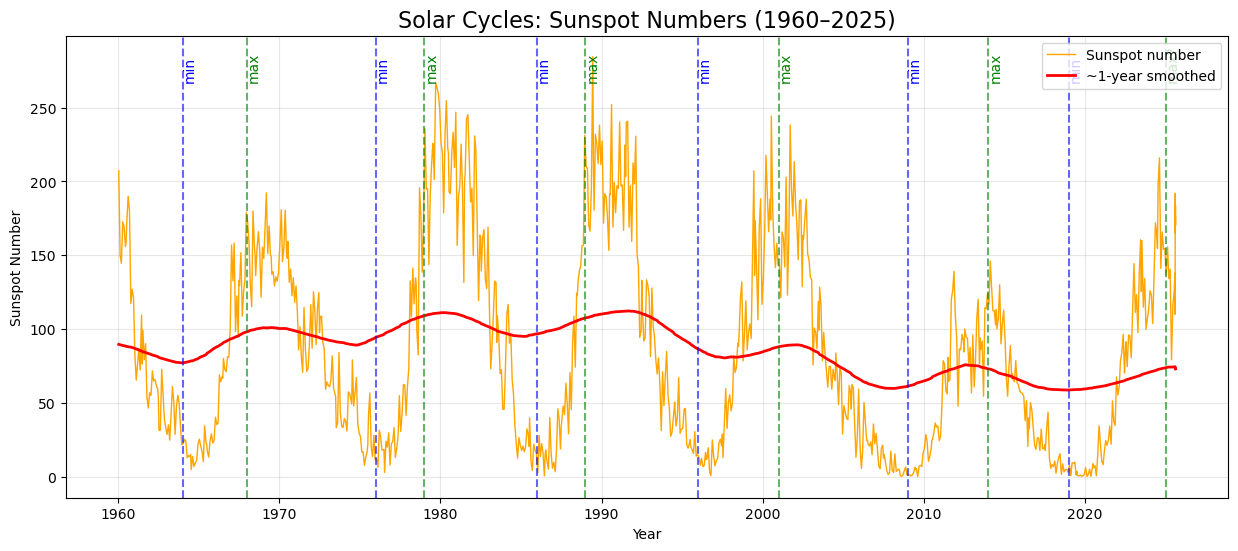

In [9]:
df = merged[(merged["date"] >= "1960-01-01") & (merged["date"] <= "2025-12-31")]

# Plot
plt.figure(figsize=(15,6))
plt.plot(df["date"], df["sunspot_number"], color="orange", linewidth=1, label="Sunspot number")

# Rolling average for smoothing (13 months ~ solar cycle trend)
df["smooth"] = df["sunspot_number"].rolling(window=365, center=True, min_periods=180).mean()
plt.plot(df["date"], df["smooth"], color="red", linewidth=2, label="~1-year smoothed")

# Mark solar cycles (approx peaks and minima known from NOAA)
cycles = [
    (1964, "min"), (1968, "max"), (1976, "min"), (1979, "max"),
    (1986, "min"), (1989, "max"), (1996, "min"), (2001, "max"),
    (2009, "min"), (2014, "max"), (2019, "min"), (2025, "max?")
]
for year, label in cycles:
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color="blue" if label=="min" else "green",
                linestyle="--", alpha=0.6)
    plt.text(pd.to_datetime(f"{year}-01-01"), plt.ylim()[1]*0.9,
             label, rotation=90, color="blue" if label=="min" else "green")

plt.title("Solar Cycles: Sunspot Numbers (1960–2025)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Sunspot Number")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('1960-2025_SolarActivityCycles.jpg', dpi=300) 
plt.show()

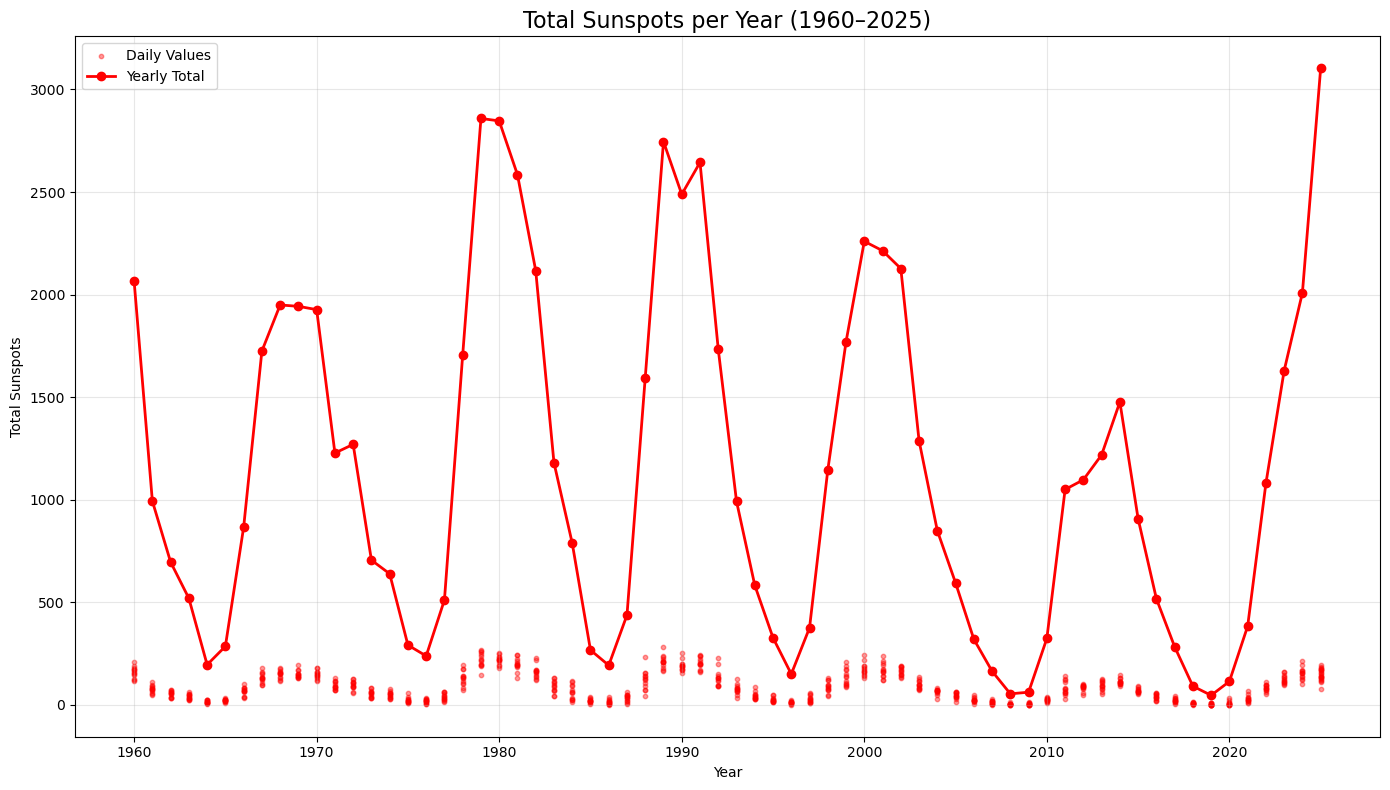

In [15]:
filtered = merged[(merged["date"].dt.year >= 1960) & (merged["date"].dt.year <= 2025)].copy()
filtered["year"] = filtered["date"].dt.year

# --- Yearly totals ---
yearly_totals = (
    filtered.groupby("year")["sunspot_number"]
    .sum()
    .reset_index()
)

# --- Plot ---
plt.figure(figsize=(14,8))

# Scatter: all daily points
plt.scatter(
    filtered["year"], 
    filtered["sunspot_number"], 
    color="red", alpha=0.4, s=10, label="Daily Values"
)

# Line: yearly totals
plt.plot(
    yearly_totals["year"], 
    yearly_totals["sunspot_number"], 
    color="red", marker="o", markersize=6, linewidth=2, label="Yearly Total"
)

plt.title("Total Sunspots per Year (1960–2025)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Total Sunspots")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

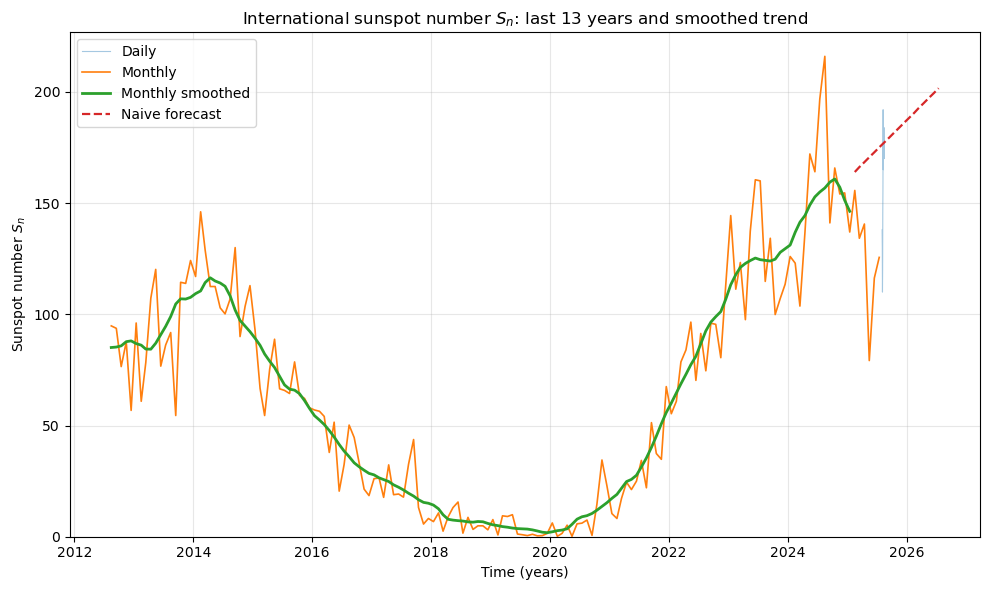

In [17]:
# ----------------------------
# Helpers
# ----------------------------
def parse_yearly(df):
    if df.shape[1] == 1:
        df = df.iloc[:,0].str.split(";", expand=True)
    df = df.rename(columns={0:"Year",1:"SunspotNumber",2:"StdDev",3:"Observations",4:"Definitive"})
    for c in df.columns: df[c] = df[c].astype(str).str.strip()
    df = df.astype({"Year": float, "SunspotNumber": float, "StdDev": float,
                    "Observations": int, "Definitive": int})
    
    # Convert "year + .5" into a datetime at mid-year
    df["Date"] = pd.to_datetime(df["Year"].astype(int).astype(str), format="%Y") \
                 + pd.to_timedelta((df["Year"] % 1 * 365.25).round().astype(int), unit="D")
    
    return df[["Date","SunspotNumber"]].set_index("Date")

def parse_monthly(df):
    if df.shape[1] == 1:
        df = df.iloc[:,0].str.split(";", expand=True)
    df = df.rename(columns={0:"Year",1:"Month",2:"DecimalDate",3:"SunspotNumber",
                            4:"StdDev",5:"Observations",6:"Definitive"})
    for c in df.columns: df[c] = df[c].astype(str).str.strip()
    df = df.astype({"Year": int, "Month": int, "DecimalDate": float,
                    "SunspotNumber": float, "StdDev": float,
                    "Observations": int, "Definitive": int})
    df["Date"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=15))
    return df[["Date","SunspotNumber"]].set_index("Date").sort_index()

def parse_daily(df):
    # If headers look wrong, rename to known SILSO layout
    expected = ["Year","Month","Day","DecimalDate","SunspotNumber",
                "StdDev","Observations1","Observations2","Definitive"]
    if list(df.columns)[:3] != ["Year","Month","Day"]:
        df = df.copy()
        df.columns = expected[:len(df.columns)]
    # dtypes
    cast = {"Year": int, "Month": int, "Day": int,
            "DecimalDate": float, "SunspotNumber": float}
    for k,v in cast.items():
        if k in df.columns:
            df[k] = pd.to_numeric(df[k], errors="coerce").astype(v)
    # date index
    df["Date"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=df["Day"]), errors="coerce")
    return df[["Date","SunspotNumber"]].dropna().set_index("Date").sort_index()

def silso_13mo_smooth(monthly_series: pd.Series) -> pd.Series:
    """
    SILSO 13-month smoothing:
    (R_-6 + R_+6)/24 + sum_{k=-5..+5}(R_k)/12
    """
    s = monthly_series.sort_index().copy()
    w = np.array([1/24] + [1/12]*11 + [1/24])   # length 13
    # Build a centered rolling window of width 13
    sm = s.rolling(window=13, center=True).apply(lambda x: np.dot(x, w), raw=True)
    return sm

def naive_linear_forecast(monthly_smoothed: pd.Series, months_ahead=18):
    """Simple linear extrapolation on the last 18 months of smoothed data."""
    y = monthly_smoothed.dropna()
    if len(y) < 6:
        return pd.Series(dtype=float)
    y_tail = y.tail(18) if len(y) >= 18 else y
    # Encode time as t = 0..n-1
    t = np.arange(len(y_tail), dtype=float)
    coeffs = np.polyfit(t, y_tail.values, 1)  # linear
    # future timeline
    last_date = y_tail.index[-1]
    future_idx = pd.date_range(last_date + pd.offsets.MonthBegin(1),
                               periods=months_ahead, freq="MS") + pd.offsets.Day(14)  # ~mid-month
    t_future = np.arange(len(y_tail), len(y_tail) + months_ahead, dtype=float)
    y_future = np.polyval(coeffs, t_future)
    return pd.Series(y_future, index=future_idx)

# ----------------------------
# Parse your three DataFrames
# ----------------------------
monthly = parse_monthly(sunSpotsMonthly)
daily = parse_daily(sunSpotsDaily)
# yearly not required for this plot, but parsed for completeness:
_ = parse_yearly(sunSpotsEarly)

# Compute 13-month smoothed monthly values (SILSO-style)
monthly_smoothed = silso_13mo_smooth(monthly["SunspotNumber"])

# Naive dashed forecast on the smoothed series
forecast = naive_linear_forecast(monthly_smoothed, months_ahead=18)

# ----------------------------
# Limit to the last ~13 years
# ----------------------------
end_date = max(monthly.index.max(), daily.index.max())
start_date = end_date - pd.DateOffset(years=13)

daily_win = daily.loc[start_date:end_date]
monthly_win = monthly.loc[start_date:end_date]
smoothed_win = monthly_smoothed.loc[start_date:end_date]

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(10, 6))

# Daily (thin, semi-transparent)
plt.plot(daily_win.index, daily_win["SunspotNumber"], label="Daily", linewidth=0.8, alpha=0.4)

# Monthly (solid)
plt.plot(monthly_win.index, monthly_win["SunspotNumber"], label="Monthly", linewidth=1.2)

# Monthly smoothed (thicker)
plt.plot(smoothed_win.index, smoothed_win, label="Monthly smoothed", linewidth=2.0)

# Forecast (dashed on the smoothed continuation)
if not forecast.empty:
    plt.plot(forecast.index, forecast.values, linestyle="--", label="Naive forecast", linewidth=1.6)

plt.title("International sunspot number $S_n$: last 13 years and smoothed trend")
plt.xlabel("Time (years)")
plt.ylabel("Sunspot number $S_n$")
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)  # keep axis clean near zero
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
df_merged = (sunSpotsDaily
             .resample("M").mean().rename(columns={"SunspotNumber":"DailyMean"})
             .join(sunSpotsMonthly.rename(columns={"SunspotNumber":"Monthly"}))
             .join(sunSpotsEarly.rename(columns={"SunspotNumber":"Yearly"}).resample("M").ffill()))

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_21456\2074947047.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M").mean().rename(columns={"SunspotNumber":"DailyMean"})


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [19]:
daily_sunSpots = sunSpotsDaily.copy()

In [20]:
columns = [
    "year",
    "month","day","decimal_date","sunspot_number",
            "std_dev","observations1","observations2","definitive"
]

In [21]:
if list(daily_sunSpots.columns)[:3] != ["year","month","day"]:
    daily_sunSpots.columns = columns[:len(daily_sunSpots.columns)]

In [22]:
daily_sunSpots.columns

Index(['year', 'month', 'day', 'decimal_date', 'sunspot_number', 'std_dev',
       'observations1', 'observations2', 'definitive'],
      dtype='object')

In [23]:
daily_sunSpots["date"] = pd.to_datetime(dict(year=daily_sunSpots["year"], month=daily_sunSpots["month"], day=daily_sunSpots["day"]), errors = 'coerce')

In [24]:
daily_sunSpots = (daily_sunSpots
    .dropna(subset=["date"])
    .set_index("date")
    .sort_index()
)

In [27]:
daily_ms = daily_sunSpots["sunspot_number"].resample("MS").mean().to_frame("DailyMean")

In [28]:
monthly_sunSpots = sunSpotsMonthly.copy()

In [33]:
first_col = monthly_sunSpots.columns[0]

In [34]:
monthly_sunSpots = (
    monthly_sunSpots[first_col]
    .astype(str)
    .str.strip()
    .str.split(r"\s*;\s*", expand=True)   # <- key bit
)

In [36]:
аssert monthly_sunSpots.shape[1] >= 7, f"Unexpected split width: {monthly_sunSpots.shape}"

SyntaxError: invalid syntax (2150579878.py, line 1)

In [32]:
if monthly_sunSpots.shape[1] == 1:
    monthly_sunSpots = monthly_sunSpots.iloc[:,0].str.split(",", expand=True)
    monthly_sunSpots.columns = [
        "year",
        "month","decimal_date","sunspot_number",
            "std_dev","observations","definitive"
]
    monthly_sunSpots = monthly_sunSpots.apply(lambda s: s.astype(str).str.strip())
    monthly_sunSpots = monthly_sunSpots.astype({"year":int,"month":int,"decimal_date":float,"sunspot_number":float,
                              "std_dev":float,"observations":int,"definitive":int}) 

ValueError: Length mismatch: Expected axis has 1 elements, new values have 7 elements